# A Teaser Example

In [205]:
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from clu import parameter_overview
import optax

import matplotlib
%matplotlib inline
matplotlib.style.use('seaborn')
import matplotlib.pyplot as plt

C:\Users\rouss\AppData\Local\Temp\ipykernel_20736\4219119754.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


## Supervised learning

In [206]:
## X-data
N = 200
X = np.random.random((N,1))
X.shape

(200, 1)

In [207]:
## Y data
sign = (- np.ones((N,))) ** np.random.randint(2, size=N)
Y = np.sqrt(X[:,0]) * sign
Y.shape

(200,)

In [208]:
## Neural Net
class NN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=10)(x)        ## Can be jitted with nn.jit
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        # x = nn.linear(x)
        return x

nn_sv = NN()
key = jax.random.PRNGKey(0)
init_data = jnp.ones((10, 2,1))
params = nn_sv.init(key, init_data)
print(nn_sv.tabulate(key, init_data))

                      NN Summary                       
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ outputs          ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs  │ float32[10,2,1]  │                        │
├─────────┼──────────────────┼────────────────────────┤
│ Dense_0 │ float32[10,2,10] │ bias: float32[10]      │
│         │                  │ kernel: float32[1,10]  │
│         │                  │                        │
│         │                  │ 20 (80 B)              │
├─────────┼──────────────────┼────────────────────────┤
│ Dense_1 │ float32[10,2,10] │ bias: float32[10]      │
│         │                  │ kernel: float32[10,10] │
│         │                  │                        │
│         │                  │ 110 (440 B)            │
├─────────┼──────────────────┼────────────────────────┤
│ Dense_2 │ float32[10,2,1]  │ bias: float32[1]       │
│         │                  │ kernel: float32[10,1]  │
│         │                  │                        │
│         │                  │ 11 (44 B)              │
├─────────┼──────────────────┼────────────────────────┤
│ NN      │ float32[10,2,1]  │                        │
├─────────┼──────────────────┼────────────────────────┤
│         │            Total │ 141 (564 B)            │
└─────────┴──────────────────┴────────────────────────┘
                                                       
             Total Parameters: 141 (564 B)             

In [209]:
## Data generator
def getbatchdata(X, Y, batch_size):
    size = X.shape[0]
    i = 0
    while i < size:
        inext = i + batch_size
        if inext > size: inext = size
        yield X[i:inext], Y[i:inext]
        i = inext

## Optimizer
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params=params)

## Loss function
# @jax.jit
def mse(params, x, y):
    ypred = nn_sv.apply(params, x).flatten()
    loss = optax.l2_loss(ypred, y)
    return jnp.mean(loss)

In [210]:
## Parameter update step. Maximum jittable block 
@jax.jit
def update_params(opt_state, params, x, y):
    grads = jax.grad(mse)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

## Training loop
Xvec = X.reshape(-1, 5, 1)
Yvec = Y.reshape(-1, 5)
for epoch in range(5):
    for x, y in getbatchdata(X, Y, batch_size=5):
        opt_state, params = update_params(opt_state, params, x, y)


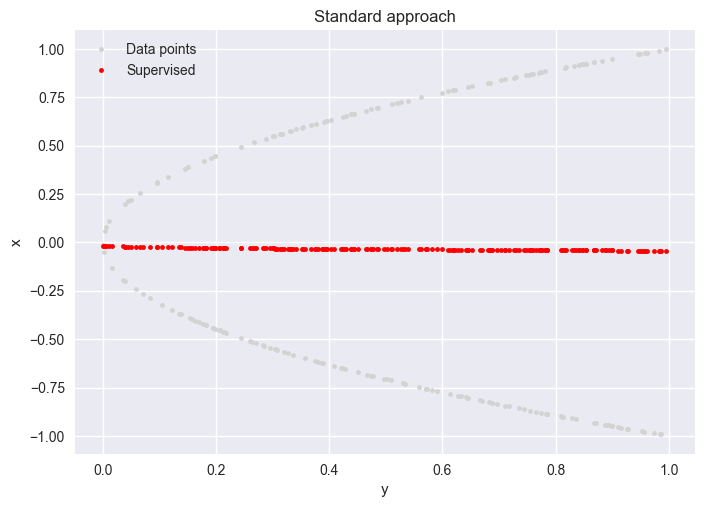

In [211]:
# Results
plt.plot(X, Y, '.', label='Data points', color="lightgray")
plt.plot(X, nn_sv.apply(params, X), '.', label='Supervised', color="red")
plt.xlabel('y')
plt.ylabel('x')
plt.title('Standard approach')
plt.legend()
plt.show()